In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torch.utils.data import Subset      # it is used to split our data
from torchvision import datasets, transforms
from torchsummary import summary
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Data loading
train_data_dir = r'C:\Users\computer\Desktop\chest\train'
test_data_dir = r'C:\Users\computer\Desktop\chest\test'

# Training transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adds color variation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop the images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Testing transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Load the training dataset with training transforms
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
trainloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Load the testing dataset with testing transforms
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)
testloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# Number of classes
num_classes = len(train_dataset.classes)
print (f'Number of class: {num_classes}')
class_names = train_dataset.classes
print (f'Name of class: {class_names}')
print (f'Train dataset:{len(train_dataset)}')
print (f'Test dataset:{len(test_dataset)}')

# Dataloaders dictionary
dataloaders = {
    'train': trainloader,
    'val': testloader  # Using testloader as validation set
}

Number of class: 2
Name of class: ['NORMAL', 'PNEUMONIA']
Train dataset:5216
Test dataset:624


In [3]:
first_batch = next(iter(trainloader))
images, labels = first_batch
print("Batch shape:", images.shape)

Batch shape: torch.Size([8, 3, 224, 224])


In [4]:
# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)


num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [6]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Initialize the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Adjust every 5 epochs

In [8]:
def training(model, dataloaders, criterion, optimizer, num_epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    val_acc_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Start timing the epoch
        start_time = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # Deep copy the model if it has the best accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
        # Step the learning rate scheduler
        scheduler.step()

        # End timing the epoch
        end_time = time.time()
        epoch_duration = end_time - start_time
        print(f'Epoch {epoch + 1} duration: {epoch_duration:.2f} seconds')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_loss_history, train_acc_history, val_loss_history


In [9]:
# Run the training
num_epochs = 50  # Set your number of epochs
best_model, val_acc_history, train_loss_history, train_acc_history, val_loss_history = training(model, dataloaders, criterion, optimizer, num_epochs)

Epoch 1/50
----------
train Loss: 0.2591 Acc: 0.8951
val Loss: 0.3139 Acc: 0.8654
Epoch 1 duration: 116.23 seconds
Epoch 2/50
----------
train Loss: 0.1947 Acc: 0.9285
val Loss: 0.5263 Acc: 0.7853
Epoch 2 duration: 118.48 seconds
Epoch 3/50
----------
train Loss: 0.1773 Acc: 0.9312
val Loss: 0.3402 Acc: 0.8686
Epoch 3 duration: 118.72 seconds
Epoch 4/50
----------
train Loss: 0.1836 Acc: 0.9287
val Loss: 0.3279 Acc: 0.8654
Epoch 4 duration: 118.65 seconds
Epoch 5/50
----------
train Loss: 0.1698 Acc: 0.9333
val Loss: 0.3897 Acc: 0.8750
Epoch 5 duration: 118.83 seconds
Epoch 6/50
----------
train Loss: 0.1602 Acc: 0.9367
val Loss: 0.2109 Acc: 0.9199
Epoch 6 duration: 118.94 seconds
Epoch 7/50
----------
train Loss: 0.1516 Acc: 0.9450
val Loss: 0.2975 Acc: 0.9022
Epoch 7 duration: 118.94 seconds
Epoch 8/50
----------
train Loss: 0.1481 Acc: 0.9477
val Loss: 0.2913 Acc: 0.9006
Epoch 8 duration: 119.68 seconds
Epoch 9/50
----------
train Loss: 0.1438 Acc: 0.9461
val Loss: 0.2840 Acc: 0.905

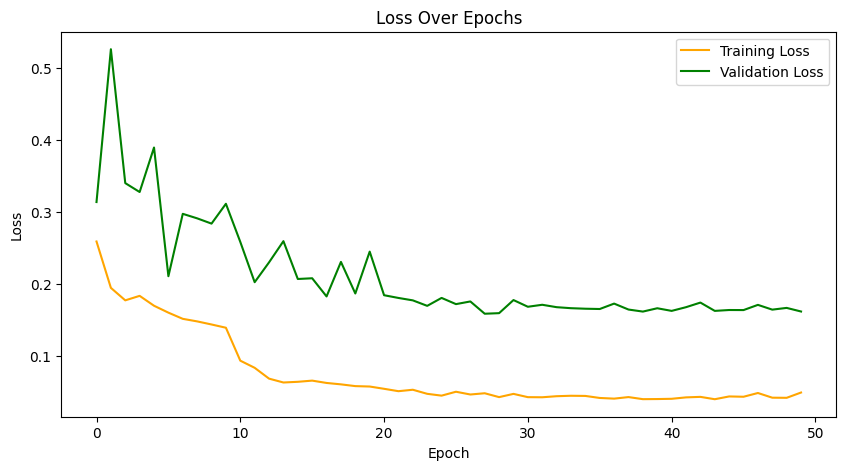

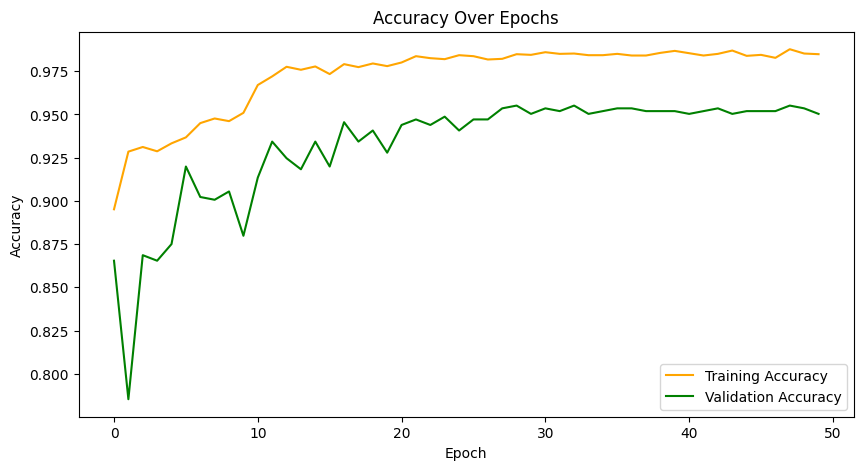

In [10]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss', color='orange')
plt.plot(val_loss_history, label='Validation Loss', color='green')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training Accuracy', color='orange')
plt.plot(val_acc_history, label='Validation Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
torch.save(model.state_dict(), 'chest_learningrate_model.pt')

In [12]:
import os
print(os.path.exists('chest_learningrate_model.pt'))

True


In [13]:
model.load_state_dict(torch.load('chest_learningrate_model.pt'))

C:\Users\computer\AppData\Local\Temp\ipykernel_8880\1851919073.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('chest_learningrate_model

<All keys matched successfully>

In [14]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track loss and accuracy
val_loss = 0.0
val_corrects = 0

# No gradient calculation needed
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        
        # Statistics
        val_loss += loss.item() * inputs.size(0)
        val_corrects += torch.sum(preds == labels.data)

# Calculate average loss and accuracy
val_loss /= len(dataloaders['val'].dataset)
val_acc = val_corrects.double() / len(dataloaders['val'].dataset)

print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')


Validation Loss: 0.1618 Acc: 0.9503


In [19]:
from sklearn.metrics import classification_report
y_true = []
y_pred = []

# Ensure the model is in evaluation mode
model.eval()
# classification report
y_true = []
y_pred = []
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.96      0.90      0.93       234
   PNEUMONIA       0.94      0.98      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.94      0.95       624
weighted avg       0.95      0.95      0.95       624



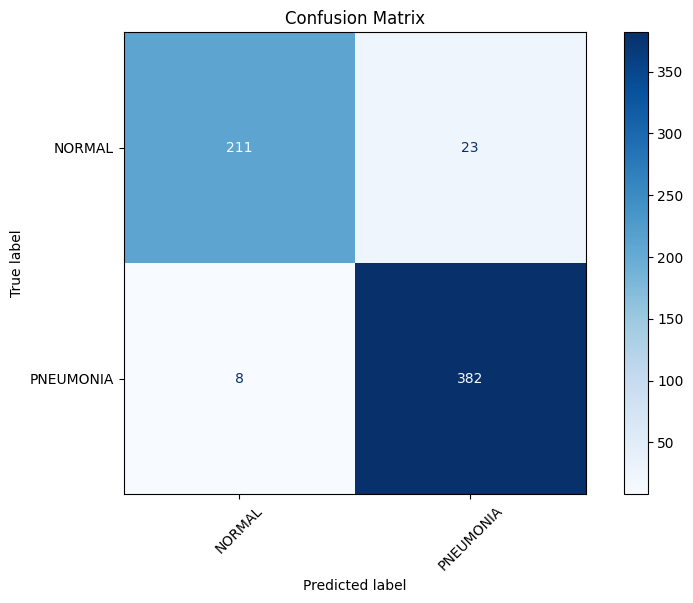

In [21]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()